# <ins>**CM3070 Computer Science Final Project**  

# **Facial Emotion Recognition with Attention-Enhanced ResNet18 for Emotion-Based Playlist Mapping**<ins>


# Dataset Preparation


---
This section handles:
- Setting up the environment and FER-2013 dataset retreival
- Inspecting initial data quality and structure
- Preprocessing data: splitting and filtering
- Visualizing dataset distribution and sample images




## Data Acquisition and Setup

Setup environment and import the dataset from Kaggle

In [ ]:
# Suppress irrelevant warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Install Kaggle API
!pip install kaggle

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to kaggle.json in Google Drive
kaggle_json_path = '/content/kaggle.json'

# Move kaggle.json to the default location and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip FER-2013 dataset
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d ./fer2013

Streaming output truncated to the last 5000 lines.
  inflating: ./fer2013/train/sad/Training_65242339.jpg  
  inflating: ./fer2013/train/sad/Training_65267116.jpg  
  inflating: ./fer2013/train/sad/Training_65275626.jpg  
  inflating: ./fer2013/train/sad/Training_6529266.jpg  
  inflating: ./fer2013/train/sad/Training_65329617.jpg  
  inflating: ./fer2013/train/sad/Training_65338712.jpg  
  inflating: ./fer2013/train/sad/Training_65338797.jpg  
  inflating: ./fer2013/train/sad/Training_65387162.jpg  
  inflating: ./fer2013/train/sad/Training_65404494.jpg  
  inflating: ./fer2013/train/sad/Training_65426218.jpg  
  inflating: ./fer2013/train/sad/Training_65430136.jpg  
  inflating: ./fer2013/train/sad/Training_65437377.jpg  
  inflating: ./fer2013/train/sad/Training_6545735.jpg  
  inflating: ./fer2013/train/sad/Training_65463385.jpg  
  inflating: ./fer2013/train/sad/Training_65473985.jpg  
  inflating: ./fer2013/train/sad/Training_65502829.jpg  
  inflating: ./fer2013/train/sad/Traini

Import required libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cv2
from collections import Counter
import shutil

Define base dataset directory

In [ ]:
base_dir = 'fer2013'  # root directory of the dataset
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

## Initial Data Inspection and Validation

Check image sizes in dataset

In [ ]:
# Function to check and counts iamge dimensions in the directory
def check_image_sizes(directory):
    size_counts = Counter()

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                # Read the image
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    # Record the dimensions
                    size_counts[img.shape] += 1
                else:
                  print(f"Unable to read image {file_path}")
    return size_counts

In [ ]:
# Check sizes for both train and test sets
size_counts_train = check_image_sizes(train_dir)
size_counts_test = check_image_sizes(test_dir)

# Print summary of iamge sizes
for size, count in size_counts_train.items():
    print(f"Test dataset - Size: {size}, Count: {count}")
for size, count in size_counts_test.items():
    print(f"Test dataset - Size: {size}, Count: {count}")

Test dataset - Size: (48, 48), Count: 28709
Test dataset - Size: (48, 48), Count: 7178


Identify missing or corrupted images in dataset

In [ ]:
# Function to check all images and detect corrupted files
# that cannot be opened correctly
def validate_images(directory):
    corrupted_files = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file in glob(os.path.join(class_path, "*.jpg")):
                try:
                    img = Image.open(file)
                    img.verify()  # Check if image is valid
                except (IOError, SyntaxError):
                    corrupted_files.append(file)
    return corrupted_files

In [ ]:
# Validate image files
corrupted_train = validate_images(train_dir)
corrupted_test = validate_images(test_dir)
print("Corrupted Training Images:", len(corrupted_train))
print("Corrupted Testing Images:", len(corrupted_test))

Corrupted Training Images: 0
Corrupted Testing Images: 0


Show folder structure

In [ ]:
# Function to display an overview of the folder structure of the dataset
def show_folder_overview(directory, level=0):
    # List all class folders
    indent = "  " * level  # Indentation to visually show hierarchy
    print(f"{indent}Folder: {directory}")

    class_folders = os.listdir(directory)
    for class_name in class_folders:
        class_name_path = os.path.join(directory, class_name)
        if os.path.isdir(class_name_path):
            # Recursively call the function for subdirectories
            show_folder_overview(class_name_path, level + 1)

show_folder_overview(train_dir)
show_folder_overview(test_dir)

Folder: fer2013/train
  Folder: fer2013/train/neutral
  Folder: fer2013/train/sad
  Folder: fer2013/train/fear
  Folder: fer2013/train/disgust
  Folder: fer2013/train/surprise
  Folder: fer2013/train/happy
  Folder: fer2013/train/angry
Folder: fer2013/test
  Folder: fer2013/test/neutral
  Folder: fer2013/test/sad
  Folder: fer2013/test/fear
  Folder: fer2013/test/disgust
  Folder: fer2013/test/surprise
  Folder: fer2013/test/happy
  Folder: fer2013/test/angry


## Data Preprocessing and Visualization

Separate `PrivateTest` and `PublicTest` data from **test** directory.
- `PublicTest` data can be used for validation
- `PrivateTest` data reserved for testing

In [ ]:
# Function to categorize test images into privatetest and publictest in the test directory
# based on their filename prefixes, ensuring proper separation for validation and testing
def categorize_images(test_dir, privatetest_dir, publictest_dir):
    # Get all emotion subdirectories in the test directory
    emotion_folders = [f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))]

    for emotion in emotion_folders:
        emotion_path = os.path.join(test_dir, emotion)
        privatetest_emotion_path = os.path.join(privatetest_dir, emotion)
        publictest_emotion_path = os.path.join(publictest_dir, emotion)

        # Create subdirectories in privatetest and publictest
        os.makedirs(privatetest_emotion_path, exist_ok=True)
        os.makedirs(publictest_emotion_path, exist_ok=True)

        # Loop through files in the emotion folder
        for file_name in os.listdir(emotion_path):
            if file_name.startswith("PrivateTest_") and file_name.endswith(".jpg"):
                shutil.move(os.path.join(emotion_path, file_name), os.path.join(privatetest_emotion_path, file_name))
            elif file_name.startswith("PublicTest_") and file_name.endswith(".jpg"):
                shutil.move(os.path.join(emotion_path, file_name), os.path.join(publictest_emotion_path, file_name))
    print("PublicTest and PrivateTest have been categorized successfully.")

# Function to remove empty directories
def remove_empty_dirs(directory):
  # Check if include empty directories
  for folder in os.listdir(directory):
      folder_path = os.path.join(directory, folder)
      if os.path.isdir(folder_path):
          remove_empty_dirs(folder_path)
          # Remove the empty folder
          if not os.listdir(folder_path):
              os.rmdir(folder_path)


In [ ]:
# Prepare directories and separate images
privatetest_dir = os.path.join(test_dir, "privatetest")
publictest_dir = os.path.join(test_dir, "publictest")
os.makedirs(privatetest_dir, exist_ok=True)
os.makedirs(publictest_dir, exist_ok=True)

# Distinguish privatetest and publictest from test dir
categorize_images(test_dir, privatetest_dir, publictest_dir)

# Remove empty directories
remove_empty_dirs(test_dir)

PublicTest and PrivateTest have been categorized successfully.


Show folder structure of dataset to identify the available emotion classes

In [ ]:
# Display an overview of the class folders in directory
def show_folder_overview(directory, level=0):
    # List all class folders in the directory
    indent = "  " * level  # Indentation to visually show hierarchy
    print(f"{indent}Folder: {directory}")

    class_folders = os.listdir(directory)
    for class_name in class_folders:
        class_name_path = os.path.join(directory, class_name)
        if os.path.isdir(class_name_path):
            # Recursively call the function for subdirectories
            show_folder_overview(class_name_path, level + 1)

show_folder_overview(train_dir)
show_folder_overview(test_dir)

Folder: fer2013/train
  Folder: fer2013/train/neutral
  Folder: fer2013/train/sad
  Folder: fer2013/train/fear
  Folder: fer2013/train/disgust
  Folder: fer2013/train/surprise
  Folder: fer2013/train/happy
  Folder: fer2013/train/angry
Folder: fer2013/test
  Folder: fer2013/test/publictest
    Folder: fer2013/test/publictest/neutral
    Folder: fer2013/test/publictest/sad
    Folder: fer2013/test/publictest/fear
    Folder: fer2013/test/publictest/disgust
    Folder: fer2013/test/publictest/surprise
    Folder: fer2013/test/publictest/happy
    Folder: fer2013/test/publictest/angry
  Folder: fer2013/test/privatetest
    Folder: fer2013/test/privatetest/neutral
    Folder: fer2013/test/privatetest/sad
    Folder: fer2013/test/privatetest/fear
    Folder: fer2013/test/privatetest/disgust
    Folder: fer2013/test/privatetest/surprise
    Folder: fer2013/test/privatetest/happy
    Folder: fer2013/test/privatetest/angry


In [ ]:
# Function to count the num of images in each subfolder in a directory
def count_images(directory):
    class_counts = {}
    total_images = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count files in the class subfolder
            count = len(glob(os.path.join(class_path, "*.jpg")))
            class_counts[class_name] = count
            # Add to total count
            total_images += count

    return class_counts, total_images

Total images in Training Set: 28709
Total images in Public Test Set: 3589
Total images in Private Test Set: 3589


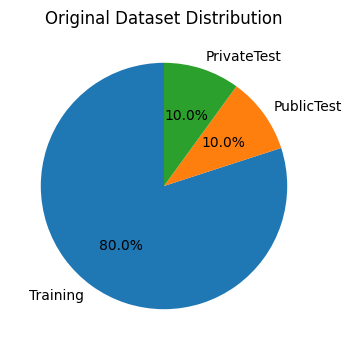

In [ ]:
# Get total counts
_, train_count = count_images(train_dir)
_, public_test_count = count_images(publictest_dir)
_, private_test_count = count_images(privatetest_dir)

# Print total counts
print("Total images in Training Set:", train_count)
print("Total images in Public Test Set:", public_test_count)
print("Total images in Private Test Set:", private_test_count)

# Plot pie chart to see the distribution of dataset
data = [train_count, public_test_count, private_test_count]
labels = ['Training', 'PublicTest', 'PrivateTest']
plt.figure(figsize=(4, 4))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Original Dataset Distribution")
plt.show()

Filter irrelevant classes

In [ ]:
# Function to remove emotion folders that are not part of the target classes
def filter_classes(directory, relevant_classes):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path) and class_name not in relevant_classes:
            # Safely remove the folder that is not relevant
            print(f"Removing unrelated folder: {class_path}")
            shutil.rmtree(class_path)

In [ ]:
# Define target classes
relevant_classes = ['happy','sad','angry','neutral']

# Filter irrelevant emotion folder
filter_classes(train_dir, relevant_classes)
filter_classes(publictest_dir, relevant_classes)
filter_classes(privatetest_dir, relevant_classes)

Removing unrelated folder: fer2013/train/disgust
Removing unrelated folder: fer2013/train/surprise
Removing unrelated folder: fer2013/train/fear
Removing unrelated folder: fer2013/test/publictest/disgust
Removing unrelated folder: fer2013/test/publictest/surprise
Removing unrelated folder: fer2013/test/publictest/fear
Removing unrelated folder: fer2013/test/privatetest/disgust
Removing unrelated folder: fer2013/test/privatetest/surprise
Removing unrelated folder: fer2013/test/privatetest/fear


In [ ]:
# Show updated folder strucutre
show_folder_overview(train_dir)
show_folder_overview(test_dir)

Folder: fer2013/train
  Folder: fer2013/train/neutral
  Folder: fer2013/train/sad
  Folder: fer2013/train/angry
  Folder: fer2013/train/happy
Folder: fer2013/test
  Folder: fer2013/test/publictest
    Folder: fer2013/test/publictest/neutral
    Folder: fer2013/test/publictest/sad
    Folder: fer2013/test/publictest/angry
    Folder: fer2013/test/publictest/happy
  Folder: fer2013/test/privatetest
    Folder: fer2013/test/privatetest/neutral
    Folder: fer2013/test/privatetest/sad
    Folder: fer2013/test/privatetest/angry
    Folder: fer2013/test/privatetest/happy


Count and plot dataset distribution

In [ ]:
# Get each class counts and total counts
train_class_count, train_total_count = count_images(train_dir)
public_class_count, publictest_total_count = count_images(publictest_dir)
private_class_count, privatetest_total_count = count_images(privatetest_dir)

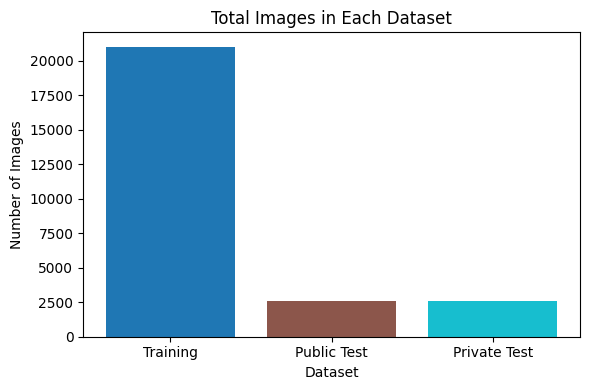

In [ ]:
# Data preparation: total counts for each dataset
datasets = ['Training', 'Public Test', 'Private Test']
total_counts = [train_total_count, publictest_total_count, privatetest_total_count]

# Create a bar plot
plt.figure(figsize=(6,4))
colors = cm.tab10(np.linspace(0, 1, len(total_counts)))
bars = plt.bar(datasets, total_counts, color=colors)
plt.bar(datasets, total_counts, color=colors)
plt.title("Total Images in Each Dataset")
plt.xlabel("Dataset")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

Training Set Class Distribution: {'neutral': 4965, 'sad': 4830, 'angry': 3995, 'happy': 7215}
Training Set Class Distribution: {'neutral': 607, 'sad': 653, 'angry': 467, 'happy': 895}
Training Set Class Distribution: {'neutral': 626, 'sad': 594, 'angry': 491, 'happy': 879}


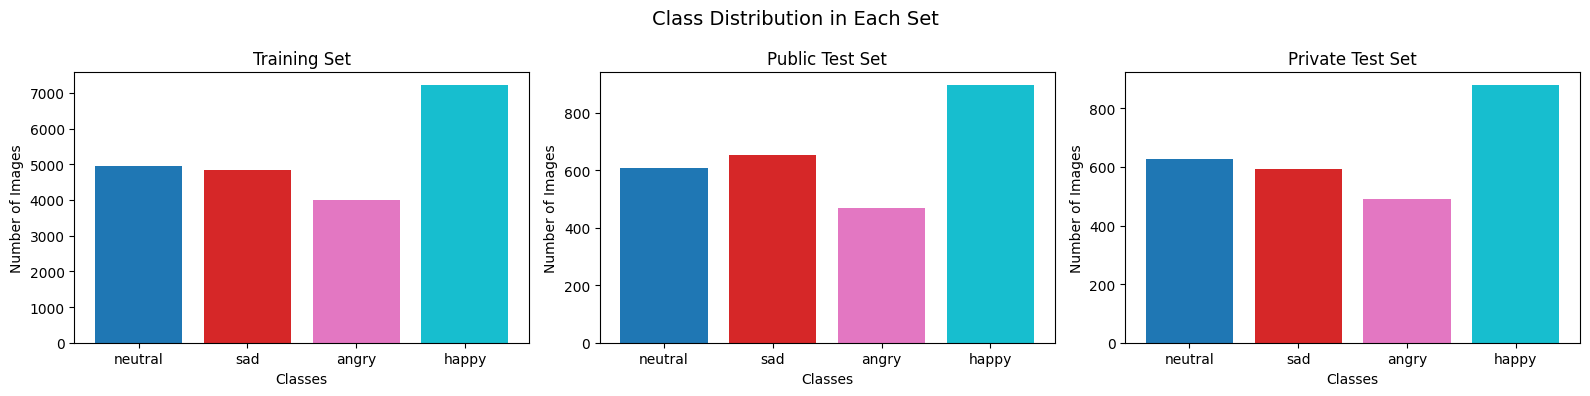

In [ ]:
# Print class counts of each dataset
print("Training Set Class Distribution:", train_class_count)
print("Training Set Class Distribution:", public_class_count)
print("Training Set Class Distribution:", private_class_count)

# Visualize the class distribution of each dataset
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)

colors = cm.tab10(np.linspace(0, 1, len(train_class_count)))
plt.bar(train_class_count.keys(), train_class_count.values(), color=colors)
plt.title("Training Set", fontsize=12)
plt.xlabel("Classes")
plt.ylabel("Number of Images")

plt.subplot(1,3,2)
colors = cm.tab10(np.linspace(0, 1, len(public_class_count)))
plt.bar(public_class_count.keys(), public_class_count.values(), color=colors)
plt.title("Public Test Set", fontsize=12)
plt.xlabel("Classes")
plt.ylabel("Number of Images")

plt.subplot(1,3,3)
colors = cm.tab10(np.linspace(0, 1, len(private_class_count)))
plt.bar(private_class_count.keys(), private_class_count.values(), color=colors)
plt.title("Private Test Set", fontsize=12)
plt.xlabel("Classes")
plt.ylabel("Number of Images")

plt.suptitle("Class Distribution in Each Set", fontsize=14)
plt.tight_layout()
plt.show()

Display sample image from each class

Visualizing Train Set Images:


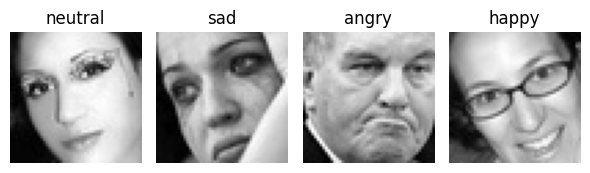

Visualizing Public Test Set Images:


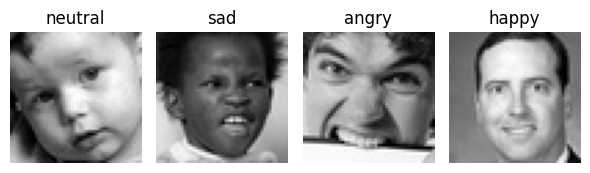

Visualizing Private Test Set Images:


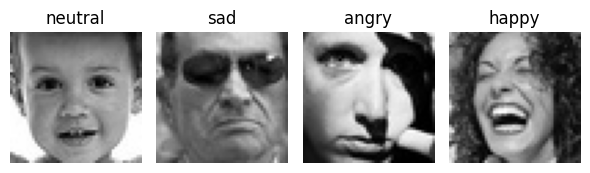

In [ ]:
# Function to display an image from each class
def display_images(directory):
    plt.figure(figsize=(6, 6))
    class_names = os.listdir(directory)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        image_files = glob(os.path.join(class_path, "*.jpg"))

        # Ensure class has at least one image
        if len(image_files) > 0:
          # Select the first image in the class folder
          img = Image.open(image_files[0])
          plt.subplot(1, len(class_names), i + 1)
          plt.imshow(img, cmap='gray')
          plt.title(class_name)
          plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images from each dataset
print("Visualizing Train Set Images:")
display_images(train_dir)
print("Visualizing Public Test Set Images:")
display_images(publictest_dir)
print("Visualizing Private Test Set Images:")
display_images(privatetest_dir)

# Model Building


---
This section implements the facial emotion recognition model (FER)



## Baseline Model: CNN Model

- Defining a basic CNN architecture for FER.
- Training and validating the baseline model.
- Evaluating accuracy, loss, precision, recall, F1-score, confusion matrix.


Install required packages and import libraries

In [ ]:
!pip install torch torchvision torchsummary

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from torchsummary import summary
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

### Dataset Preparation
This section covers:
- Loading and preprocessing the dataset
- Verifying dataset integrity
- Inspecting dataset structure and class distribution
- Visualizing sample images for analysis

Prepare the dataset and create dataloader

In [ ]:
# Function to preprocess dataset
# by loading images from directory, resizes, normalization, and converts to numpy
def preprocess_dataset(directory, target_size, normalize=True):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))

    # Iterate through class folders
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                # Load image in grayscale
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Resize to target size
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(label)

    # Convert to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int')

    # Normalize pixel values
    if normalize:
        images = images / 255.0  # Scale to [0, 1]

    # Add channel dimension and convert to PyTorch tensors
    images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
    labels_tensor = torch.tensor(labels, dtype=torch.int64)

    # Create TensorDataset
    dataset = TensorDataset(images_tensor, labels_tensor)

    return dataset, class_names

Load datasets and dataloaders

In [ ]:
train_dataset, class_names_train = preprocess_dataset(train_dir, target_size=(48, 48))
val_dataset, class_names_val = preprocess_dataset(publictest_dir, target_size=(48, 48))
test_dataset, class_names_test = preprocess_dataset(privatetest_dir, target_size=(48, 48))

assert class_names_train == class_names_val == class_names_test, "Class names do not match across datasets!"

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Verify dataset integrity after preprocessing

In [ ]:
# Check image size
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

print("-----------------------------------------------------")
# Check image shapes
X_train, y_train = train_dataset.tensors  # Extract image and label tensors
X_val, y_val = val_dataset.tensors
X_test, y_test = test_dataset.tensors

print(f"Training images shape: {X_train.shape}")  # (num_samples, 1, height, width)
print(f"Training labels shape: {y_train.shape}")  # (num_samples,)
print(f"Validation images shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test images shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training dataset size: 21005
Validation dataset size: 2622
Test dataset size: 2590
-----------------------------------------------------
Training images shape: torch.Size([21005, 1, 48, 48])
Training labels shape: torch.Size([21005])
Validation images shape: torch.Size([2622, 1, 48, 48])
Validation labels shape: torch.Size([2622])
Test images shape: torch.Size([2590, 1, 48, 48])
Test labels shape: torch.Size([2590])


In [ ]:
# Verify pixel range
images, _ = next(iter(train_loader))
print("Pixel value range in training set:", images.min().item(), "to", images.max().item())

Pixel value range in training set: 0.0 to 1.0


In [ ]:
# Function to calculate class distribution
def calculate_class_distribution(dataset, class_names=None):
  _, labels = dataset.tensors
  label_counts = Counter(labels.tolist())  # Count label occurrences

  # Ensure all classes are included, starting from 0
  total_classes = max(label_counts.keys()) + 1
  formatted_counts = {i: label_counts.get(i, 0) for i in range(total_classes)}

  return formatted_counts

# Calculate distributions
train_distribution = calculate_class_distribution(train_dataset)
val_distribution = calculate_class_distribution(val_dataset)
test_distribution = calculate_class_distribution(test_dataset)
print(f"Class distribution in Training Set: {train_distribution}")
print(f"Class distribution in Validation Set: {val_distribution}")
print(f"Class distribution in Test Set: {test_distribution}")

Class distribution in Training Set: {0: 3995, 1: 7215, 2: 4965, 3: 4830}
Class distribution in Validation Set: {0: 467, 1: 895, 2: 607, 3: 653}
Class distribution in Test Set: {0: 491, 1: 879, 2: 626, 3: 594}


Visualize sample images

Visualizing Train Set Images:


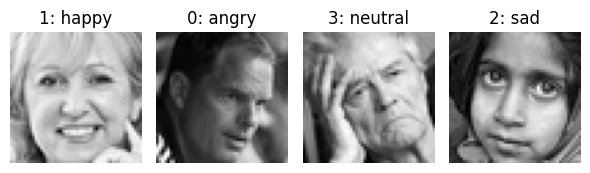

Visualizing Public Test Set Images:


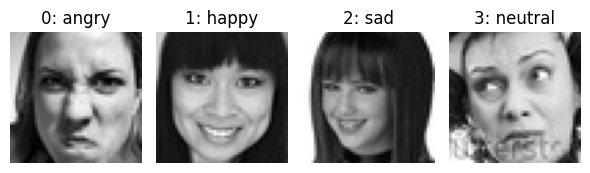

Visualizing Private Test Set Images:


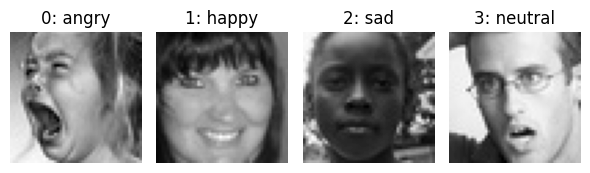

In [ ]:
class_names = ['angry', 'happy', 'sad','neutral']

# Function to display image from each class
def image_per_class(loader, class_names):
  class_seen = set()
  images, labels = [], []

  # Iterate through the dataloader
  for batch_images, batch_labels in loader:
      for img, lbl in zip(batch_images, batch_labels):
          if lbl.item() not in class_seen:  # Check if class has been displayed
              images.append(img.squeeze(0).numpy())  # Remove channel dimension
              labels.append(lbl.item())
              class_seen.add(lbl.item())
          if len(class_seen) == len(class_names):  # Stop once all classes are covered
              break
      if len(class_seen) == len(class_names):
          break

  # Plot one image per class
  plt.figure(figsize=(6, 6))  # Adjust figure size as needed
  for i, (img, lbl) in enumerate(zip(images, labels)):
      plt.subplot(1, len(class_names), i + 1)  # Create a subplot for each class
      plt.imshow(img, cmap='gray')  # Display the image
      plt.title(f"{lbl}: {class_names[lbl]}")  # Show label and class name
      plt.axis('off')  # Turn off axis for better visualization
  plt.tight_layout()
  plt.show()


# Display images from the dateset
print("Visualizing Train Set Images:")
image_per_class(train_loader, class_names)
print("Visualizing Public Test Set Images:")
image_per_class(val_loader, class_names)
print("Visualizing Private Test Set Images:")
image_per_class(test_loader, class_names)

### Model Training and Evaluation

Define CNN Baseline Model

In [ ]:
class CNNBaseline(nn.Module):
    def __init__(self, num_classes):
        super(CNNBaseline, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.relu1 = nn.ReLU()                                   # ReLU activation
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)       # Max pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Second convolutional layer
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Third convolutional layer
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)      # Final pooling
        self.flatten = nn.Flatten()                             # Flatten layer
        self.fc1 = nn.Linear(128 * 6 * 6, 128)                  # Fully connected layer
        self.fc2 = nn.Linear(128, num_classes)                  # Output layer for classification

    def forward(self, x):
        x = self.conv1(x)   # Apply first convolution
        x = self.relu1(x)   # Apply ReLU
        x = self.pool1(x)   # Apply Max Pooling
        x = self.conv2(x)   # Apply second convolution
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)   # Apply third convolution
        x = self.relu3(x)
        x = self.pool3(x)   # Final pooling
        x = self.flatten(x) # Flatten for fully connected layers
        x = self.fc1(x)     # Apply first fully connected layer
        x = self.fc2(x)     # Apply output layer
        return x


Initialize the model, loss function, and optimizer

In [ ]:
# Extract labels from the training dataset tensor
_, y_train = train_dataset.tensors

# Convert labels to NumPy array
y_train_np = y_train.numpy()

# Determine the num of output classes based on the training dataset
num_classes = len(class_names_train)

# Set the computation device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = CNNBaseline(num_classes=num_classes).to(device)

# Compute class weights for imbalanced classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train_np
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Class weights: {class_weights}")

# Configure the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Set up early stopping params
early_stopping_patience = 3
best_val_loss = float('inf')  # Best validation loss
early_stopping_counter = 0  # Track consecutive epochs with no improvement

Class weights: [1.31445557 0.72782398 1.05765358 1.08721532]


In [ ]:
summary(model,input_size = (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          18,496
              ReLU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
              ReLU-8          [-1, 128, 12, 12]               0
         MaxPool2d-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                  [-1, 128]         589,952
           Linear-12                    [-1, 4]             516
Total params: 683,140
Trainable params: 683,140
Non-trainable params: 0
-------------------------------

The CNN baseline model training loop performs batch training with loss, loss/accuracy tracking for each epochs, and early stopping.

In [ ]:
# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the num of epochs for training
epochs = 20

# Training and Validation loop
for epoch in range(epochs):
  # ---------- Training ---------
  model.train()
  train_loss = 0.0
  correct_train = 0
  total_train = 0

  # Iterate over the training data in batches
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()              # Clear gradients
      outputs = model(images)            # Forward pass
      loss = criterion(outputs, labels)  # Compute loss
      loss.backward()                    # Backward pass
      optimizer.step()                   # Update weights
      train_loss += loss.item()          # Accumultae batch loss

      # Compute training accuracy
      _, predicted_train = torch.max(outputs, 1)
      total_train += labels.size(0)
      correct_train += (predicted_train == labels).sum().item()

  # Calculate average training loss and accuracy for epoch
  train_loss /= len(train_loader)
  train_accuracy = correct_train / total_train
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # ---------- Validation ---------
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0

  # Disable gradient computation
  with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(inputs)            # Forward pass
          loss = criterion(outputs, labels)  # Compute validation loss
          val_loss += loss.item()            # Accumulate batch loss

          # Compute validation accuracy
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  # Calculate average validation loss and accuracy for epoch
  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_accuracy = correct / total
  val_accuracies.append(val_accuracy)

  print(f"Epoch {epoch + 1}/{epochs}, "
        f"Training Loss: {train_loss:.4f},"
        f"Validation Loss: {val_loss:.4f},"
        f"Validation Accuracy: {val_accuracy:.4f}")

  # --------- Early stopping ---------
  if val_loss < best_val_loss:
      best_val_loss = val_loss    # Update the best validation loss
      early_stopping_counter = 0  # Reset the counter for early stopping
      torch.save(model.state_dict(), "best_baseline.pth")  # Save the best model
  else:
      early_stopping_counter += 1
      if early_stopping_counter >= early_stopping_patience:
          print("Early stopping triggered.")
          break

Epoch 1/20, Training Loss: 1.3249, Validation Loss: 1.2353, Validation Accuracy: 0.4588
Epoch 2/20, Training Loss: 1.1982, Validation Loss: 1.1382, Validation Accuracy: 0.5019
Epoch 3/20, Training Loss: 1.1377, Validation Loss: 1.1173, Validation Accuracy: 0.5175
Epoch 4/20, Training Loss: 1.0939, Validation Loss: 1.0637, Validation Accuracy: 0.5412
Epoch 5/20, Training Loss: 1.0625, Validation Loss: 1.0399, Validation Accuracy: 0.5484
Epoch 6/20, Training Loss: 1.0370, Validation Loss: 1.0449, Validation Accuracy: 0.5534
Epoch 7/20, Training Loss: 1.0092, Validation Loss: 1.0087, Validation Accuracy: 0.5706
Epoch 8/20, Training Loss: 0.9939, Validation Loss: 1.0082, Validation Accuracy: 0.5648
Epoch 9/20, Training Loss: 0.9778, Validation Loss: 1.0084, Validation Accuracy: 0.5767
Epoch 10/20, Training Loss: 0.9612, Validation Loss: 1.0266, Validation Accuracy: 0.5694
Epoch 11/20, Training Loss: 0.9505, Validation Loss: 0.9963, Validation Accuracy: 0.5809
Epoch 12/20, Training Loss: 0.

Plot the validation accuracy and loss

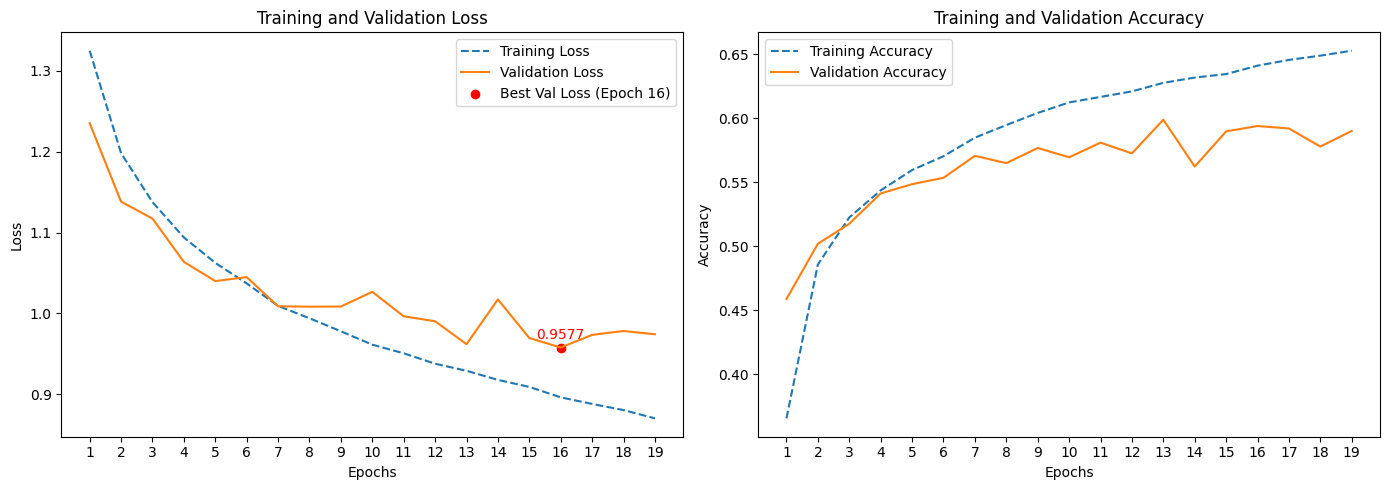

In [ ]:
# Find the epoch with the best validation loss
best_epoch = val_losses.index(min(val_losses))  # Index of the lowest validation loss
best_val_loss = val_losses[best_epoch]          # Value of the lowest validation loss

# Create the epoch range for x-axis ticks
epochs_range = range(1, len(train_losses) + 1)

# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss", linestyle='--')
plt.plot(epochs_range, val_losses, label="Validation Loss", linestyle='-')
plt.scatter(best_epoch + 1, best_val_loss, color='red', label=f"Best Val Loss (Epoch {best_epoch + 1})")  # Red marker
plt.text(best_epoch + 1, best_val_loss + 0.01, f"{best_val_loss:.4f}", color='red', fontsize=10, ha='center')
plt.xticks(epochs_range)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy", linestyle='--')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", linestyle='-')
plt.xticks(epochs_range)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig("baseline_val_accuracy_loss.png")
plt.show()


**Training and Validation Loss:**
- **Training Loss** decreases steadily over epochs, showing that the model is learning from the training data.
- **Validation Loss** decrease intially, but starts fluctuating and slightly increasing after epoch 5.

The fluctuation in validation loss after epoch 4 demonstrates potential overfitting, were the model starts fitting the training data too closely and struggles to generalize to unseen validation data.

**Validation Accuracy:**
- Validation accuracy improves rapidly in the first few epochs and stabilizes around 0.56-0.58 after epoch 4.
- Accuracy fluctuates slightly but does not show a significant decline, indicating that the model's generalization is relatviely stable.

The stabilization of validation accuracy suggests that the model is learning meaningful patterns, but the improvement slows donw after the early epochs. Fluctuations in accuracy could be cauased by noise in the validation set of minor overfitting.

In [ ]:
# Load the best model with the lowest validation loss
model.load_state_dict(torch.load("best_baseline.pth"))

<All keys matched successfully>

Evaluate the model by generating classification report and confusion matrix

In [ ]:
# Function to evaluate the model on training, validation, and test data
def calculate_accuracy(loader, model, device):
   # Set the model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    # Disable gradient computation
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
train_accuracy = calculate_accuracy(train_loader, model, device)
val_accuracy = calculate_accuracy(val_loader, model, device)
test_accuracy = calculate_accuracy(test_loader, model, device)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.6580
Validation Accuracy: 0.5938
Test Accuracy: 0.6000



Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.59      0.54       491
       happy       0.82      0.77      0.79       879
     neutral       0.58      0.42      0.49       626
         sad       0.45      0.55      0.49       594

    accuracy                           0.60      2590
   macro avg       0.59      0.58      0.58      2590
weighted avg       0.61      0.60      0.60      2590



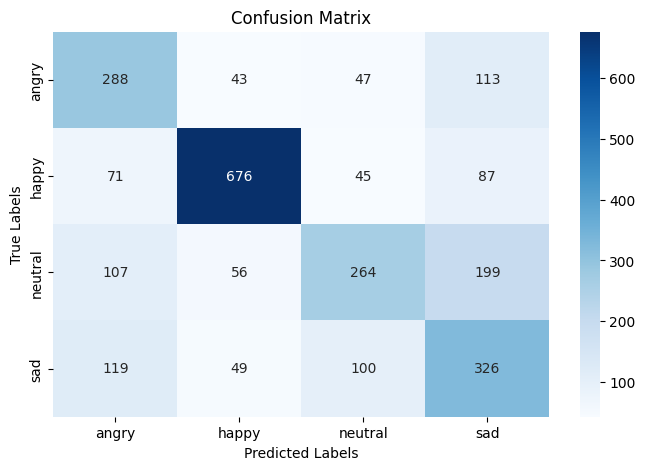

In [ ]:
# Evaluate the model on the test set to generate predictions
model.eval()
all_labels = []
all_predictions = []

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Classification Report
print("\nClassification Report:")
report = classification_report(all_labels, all_predictions, target_names=class_names_train)
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_train, yticklabels=class_names_train)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("baseline_model_conf_matrix.png")
plt.show()

**Observation Summary for Baseline CNN Model Training**


---


**Overall Performance**
- The baseline CNN model achieves 60% accuracy with a macro-average F1-score of 0.58 and a weighted F1-score of 0.60.
- Performance is imbalanced across emotions, with "happy" being the most accurately classified, while "neutral" and "sad" exhibit significant misclassification.

**Class-wise Performance**
- **Happy**: Best-performing class (F1-score: 0.79, Precision: 0.82, Recall: 0.77**), with 676 correct classifications.
- **Neutral**: Moderate performance (F1-score: 0.49), frequently misclassified as sad (199 instances) or angry (107 instances).
- **Angry**: Struggles with precision (0.49) and recall (0.59), often misclassified as sad or neutral.
- **Sad**: F1-score: 0.49, frequently confused with neutral (100 instances misclassified).

**Key Issues**
1. **Misclassification of Similar Emotions**: High confusion between neutral and sad, angry and sad, suggesting difficulty in distinguishing subtle facial expressions.  

2. **Class Imbalance**: The model performs better on happy emotions, possibly due to dataset bias.  

3. **Underfitting** : A 60% accuracy rate suggests the need for a more complex architecture.  

**Conclusion**
The baseline CNN provides a starting point, but enhancing the model and refining data processing is crucial for better performance.


## Proposed Model: ResNet18+CBAM
- Implementing an enhanced deep learning model using ResNet18 with Convolutional Block Attention Module (CBAM)
- Training and validating the baseline model.
- Evaluating accuracy, loss, precision, recall, F1-score, confusion matrix, ensuring that the evaluation results is better than baseline model.

Install required packages and import libraries

In [ ]:
!pip install torch torchvision torchsummary

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms, models
from torchsummary import summary
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

### Dataset Preparation
This section covers:
- Loading and preprocessing the dataset
- Data augmentation for training
- Verifying dataset integrity
- Visualizing sample images for analysis

Prepare the dataset and create dataloader


In [ ]:
# Function to preprocess and prepare dataset
def preprocess_dataset(directory, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))

    # Iterate through class folders
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                # Load image in grayscale
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Resize to target size
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(label)

    # Convert to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int')

    return images, labels, class_names

Load datasets and dataloaders

In [ ]:
X_train, y_train, class_names_train = preprocess_dataset(train_dir, target_size=(224, 224))
X_val, y_val, class_names_val = preprocess_dataset(publictest_dir, target_size=(224, 224))
X_test, y_test, class_names_test = preprocess_dataset(privatetest_dir, target_size=(224, 224))

assert class_names_train == class_names_val == class_names_test, "Class names do not match across datasets!"

Normalize pixel values

In [ ]:
raw_mean = X_train.mean() / 255.0
raw_std = X_train.std() / 255.0

print("Dataset Statistics before normalization:")
print(f"Mean: {raw_mean:.4f}, Std: {raw_std:.4f}")

Dataset Statistics before normalization:
Mean: 0.4922, Std: 0.2486


Define transformations for training and testing

In [ ]:
# Augmentation pipeline for training dataset
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4922], std=[0.2486]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0),
])

# No augmentation pipeline for validation and testing dataset
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4922], std=[0.2486])
])

Define dataset wrapper that applies spcecific transformations for each image class

In [ ]:
class CustomAugmentedDataset(Dataset):
    def __init__(self, images, labels, augmentations):
        self.images = images
        self.labels = labels
        self.augmentations = augmentations

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert grayscale image (NumPy) to PIL Image for PyTorch transforms
        image = Image.fromarray(image.astype('uint8'))

        # Apply class-specific augmentation
        augmentation = self.augmentations[label]
        image = augmentation(image)

        return image, label

Define augmentation mapping

In [ ]:
# Create datasets
train_dataset = CustomAugmentedDataset(X_train, y_train, {i: train_transforms for i in range(4)})
val_dataset = CustomAugmentedDataset(X_val, y_val, {i: val_transforms for i in range(4)})
test_dataset = CustomAugmentedDataset(X_test, y_test, {i: val_transforms for i in range(4)})

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Verify pixel value range, mean and standard deviation

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Check shapes and data types
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Images dtype: {images.dtype}")
print(f"Labels dtype: {labels.dtype}")

# Check statistics after normalization
print("Post-Normalization Statistics:")
print(f"Pixel Value Range: Min = {images.min().item()}, Max = {images.max().item()}")
print(f"Mean: {images.mean().item():.4f}, Std: {images.std().item():.4f}")

Images batch shape: torch.Size([32, 1, 224, 224])
Labels batch shape: torch.Size([32])
Images dtype: torch.float32
Labels dtype: torch.int64
Post-Normalization Statistics:
Pixel Value Range: Min = -1.9798872470855713, Max = 2.0426385402679443
Mean: -0.0972, Std: 1.0931


Inspect augmentated images of each class




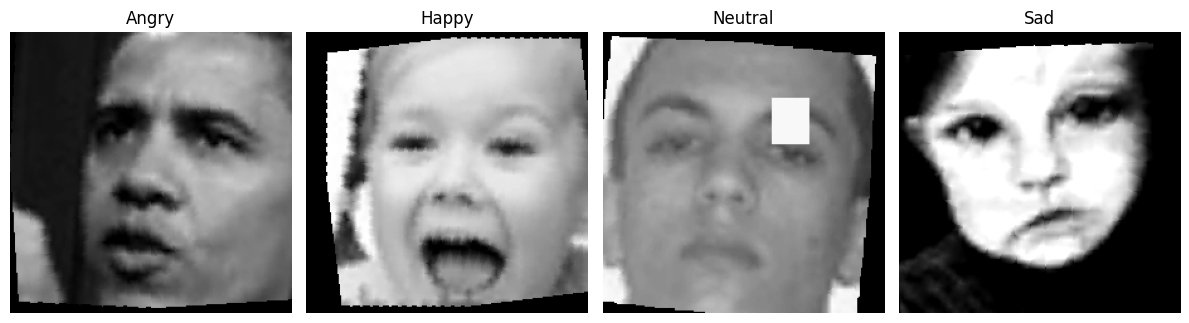

In [ ]:
# Function to visualize an image per class
def show_augmented_images_by_class(dataset, num_classes, class_names=None):
    # Dictionary to store one image per class
    images_by_class = {}

    # Iterate through the dataset to collect one image per class
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label not in images_by_class:
            images_by_class[label] = image
        if len(images_by_class) == num_classes:
            break

    # Plot the images
    fig, axs = plt.subplots(1, num_classes, figsize=(12, 6))
    for i, (label, image) in enumerate(sorted(images_by_class.items())):
        # Convert image tensor to a format suitable for plotting
        image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        axs[i].imshow(image, cmap='gray' if image.shape[2] == 1 else None)
        class_name = class_names[label] if class_names else f"Class {label}"
        axs[i].title.set_text(class_name)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize augmented images
num_classes = len(set(y_train))
class_names = ["Angry", "Happy", "Neutral", "Sad"]
show_augmented_images_by_class(train_dataset, num_classes, class_names=class_names)


### Model Training and Evaluation

Define CBAM attention mechanism

In [ ]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool = torch.amax(x, dim=(2, 3))
        avg_out = self.fc2(self.relu(self.fc1(avg_pool)))
        max_out = self.fc2(self.relu(self.fc1(max_pool)))
        out = self.sigmoid(avg_out + max_out).unsqueeze(2).unsqueeze(3)
        return x * out


# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_pool, max_pool], dim=1)
        out = self.sigmoid(self.conv(concat))
        return x * out


# CBAM Block
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

Define the ResNet18 model with CBAM

In [ ]:
# ResNet18 with CBAM for Grayscale Input
class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18_CBAM, self).__init__()
        self.base_model = models.resnet18(pretrained=True)  # Load pre-trained ResNet18

        # Modify the first convolutional layer to accept 1-channel input (grayscale)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # CBAM applied after Conv5_x (512 channels)
        self.cbam = CBAM(512)

        # Replace the final fully connected layer to match the number of classes
        self.base_model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Forward pass through ResNet18's convolutional blocks
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

        # Apply CBAM after Conv5_x
        x = self.cbam(x)

        # Global average pooling and final classification
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

##### Initial training

Initialize the model, loss function, and optmizer

In [ ]:
# Determine the num of output classes based on the training dataset
num_classes = len(class_names_train)
# Set the computation device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model
model = ResNet18_CBAM(num_classes=num_classes).to(device)

# Compute class weights to handle imbalanced classes in the training dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Function to handle class imbalance and improve performance on underrepresented classes
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        p_t = torch.exp(-ce_loss)  # Compute the probabilities of correct class
        focal_loss = (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()


# Configure the optimizer, learning rate scheduler, and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = FocalLoss(alpha=class_weights_tensor, gamma=2)  # focal loss

# Set up early stopping params
early_stopping_patience = 5
best_val_loss = float('inf')  # Best validation loss
early_stopping_counter = 0  # Track consecutive epochs with no improvement

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [ ]:
print(model)

ResNet18_CBAM(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
summary(model,input_size = (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

The Resnet18-CBAM model training loop performs batch training with loss, loss/accuracy tracking for each epochs, and early stopping.

In [ ]:
# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the num of epochs for training
epochs = 20

# Training and Validation loop
for epoch in range(epochs):
  # ---------- Training ---------
  model.train()
  train_loss = 0.0
  correct_train = 0
  total_train = 0

  # Iterate over the training data in batches
  for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()               # Clear gradients
      outputs = model(inputs)             # Forward pass
      loss = criterion(outputs, labels)   # Compute loss
      loss.backward()                     # Backward pass
      optimizer.step()                    # Update weights
      train_loss += loss.item()           # Accumulate batch loss

      # Compute training accuracy
      _, predicted = torch.max(outputs, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()

  # Calculate average training loss and accuracy for epoch
  train_loss /= len(train_loader)
  train_accuracy = correct_train / total_train
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # ---------- Validation ---------
  model.eval()
  val_loss = 0.0
  correct_val = 0
  total_val = 0

  # Disable gradient computation
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs)            # Forward pass
          loss = criterion(outputs, labels)  # Compute validation loss
          val_loss += loss.item()            # Accumulate batch loss

          # Compute validation accuracy
          _, predicted = torch.max(outputs, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

  # Calculate average validation loss and accuracy for epoch
  val_loss /= len(val_loader)
  val_accuracy = correct_val / total_val
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # Print epoch results
  print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

  # Step the scheduler to adjust the learning rate
  scheduler.step()

  # --------- Early stopping ---------
  if val_loss < best_val_loss:
      best_val_loss = val_loss    # Update the best validation loss
      early_stopping_counter = 0  # Reset the counter for early stopping
      torch.save(model.state_dict(), "best_model.pth")  # Save best model
  else:
      early_stopping_counter += 1
      if early_stopping_counter >= early_stopping_patience:
          print("Early stopping triggered.")
          break


Epoch 1/20, Training Loss: 0.6337, Validation Loss: 0.5565, Validation Accuracy: 0.5393
Epoch 2/20, Training Loss: 0.4964, Validation Loss: 0.4783, Validation Accuracy: 0.6453
Epoch 3/20, Training Loss: 0.4536, Validation Loss: 0.4478, Validation Accuracy: 0.6556
Epoch 4/20, Training Loss: 0.4252, Validation Loss: 0.4208, Validation Accuracy: 0.6651
Epoch 5/20, Training Loss: 0.4027, Validation Loss: 0.3989, Validation Accuracy: 0.6793
Epoch 6/20, Training Loss: 0.3398, Validation Loss: 0.3661, Validation Accuracy: 0.7094
Epoch 7/20, Training Loss: 0.3151, Validation Loss: 0.3631, Validation Accuracy: 0.7113
Epoch 8/20, Training Loss: 0.3062, Validation Loss: 0.3566, Validation Accuracy: 0.7128
Epoch 9/20, Training Loss: 0.2951, Validation Loss: 0.3541, Validation Accuracy: 0.7243
Epoch 10/20, Training Loss: 0.2817, Validation Loss: 0.3485, Validation Accuracy: 0.7178
Epoch 11/20, Training Loss: 0.2712, Validation Loss: 0.3512, Validation Accuracy: 0.7227
Epoch 12/20, Training Loss: 0.

Plot the validation accuracy and loss

Validation loss/accuracy plot saved to: /content/drive/My Drive/Share/FER_fyp/Proposed_Model/model_init_val_loss_acc.png


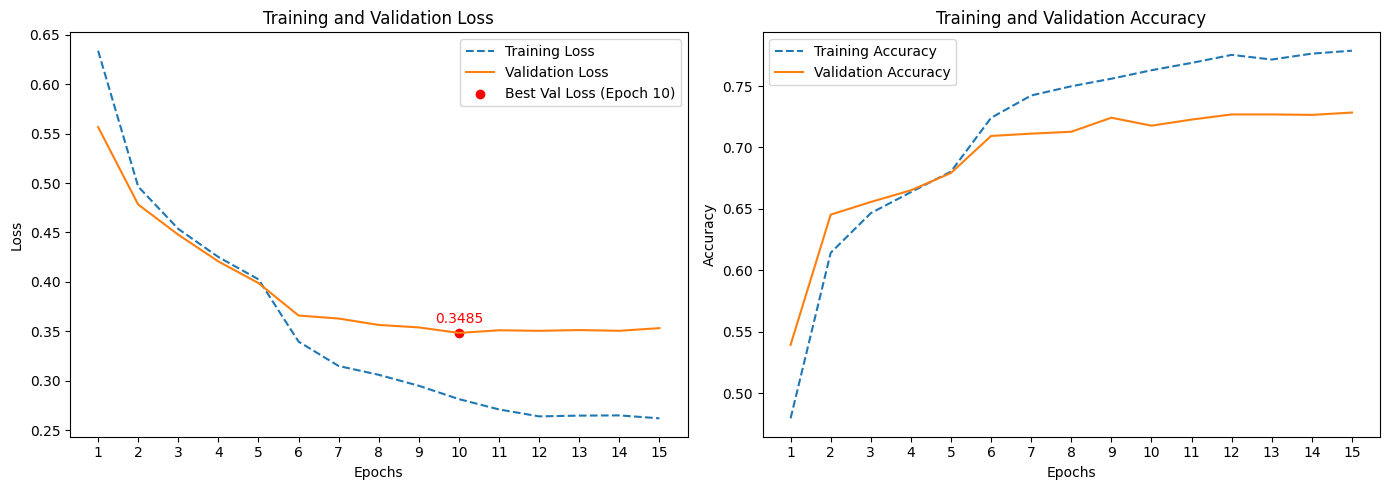

In [ ]:
# Find the epoch with the best validation loss
best_epoch = val_losses.index(min(val_losses))  # Index of the lowest validation loss
best_val_loss = val_losses[best_epoch]          # Value of the lowest validation loss

# Create the epoch range for x-axis ticks
epochs_range = range(1, len(train_losses) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss", linestyle='--')
plt.plot(epochs_range, val_losses, label="Validation Loss", linestyle='-')
plt.scatter(best_epoch + 1, best_val_loss, color='red', label=f"Best Val Loss (Epoch {best_epoch + 1})")  # Red marker
plt.text(best_epoch + 1, best_val_loss + 0.01, f"{best_val_loss:.4f}", color='red', fontsize=10, ha='center')
plt.xticks(epochs_range)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy", linestyle='--')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", linestyle='-')
plt.xticks(epochs_range)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig("model_init_val_loss_acc.png")
# Save confusion matrix plot to GD
val_loss_acc_path = os.path.join(drive_save_dir, "model_init_val_loss_acc.png")
plt.savefig(val_loss_acc_path)  # Save plot to GD
print(f"Validation loss/accuracy plot saved to: {val_loss_acc_path}")
plt.show()


In [ ]:
# Load the best model with the lowest validation loss
model.load_state_dict(torch.load("best_model.pth"))

Evaluate the model

In [ ]:
# Function to evaluate the model on training, validation, and test data
def calculate_accuracy(loader, model, device):
   # Set the model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    # Disable gradient computation
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
train_accuracy = calculate_accuracy(train_loader, model, device)
val_accuracy = calculate_accuracy(val_loader, model, device)
test_accuracy = calculate_accuracy(test_loader, model, device)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.7739
Validation Accuracy: 0.7178
Test Accuracy: 0.7548



Classification Report:
              precision    recall  f1-score   support

       angry       0.68      0.75      0.71       491
       happy       0.93      0.87      0.90       879
     neutral       0.68      0.73      0.70       626
         sad       0.66      0.62      0.64       594

    accuracy                           0.75      2590
   macro avg       0.74      0.74      0.74      2590
weighted avg       0.76      0.75      0.76      2590

Confusion matrix plot saved to: /content/drive/My Drive/Share/FER_fyp/Proposed_Model/model_init_conf_matrix.png


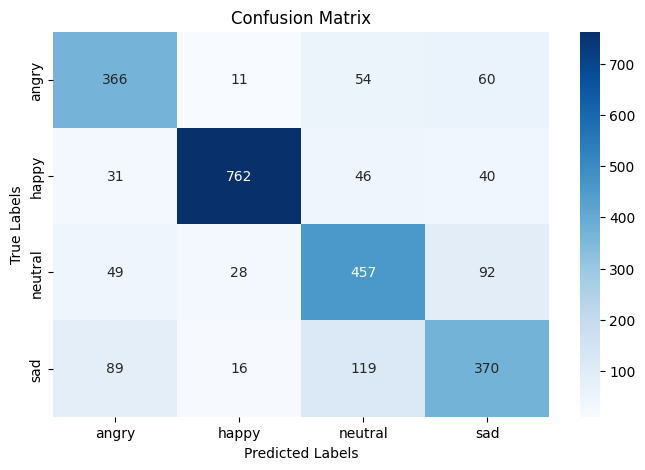

In [ ]:
# Evaluate the model on the test set to generate predictions
model.eval()
all_labels = []
all_predictions = []

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Classification Report
print("\nClassification Report:")
report = classification_report(all_labels, all_predictions, target_names=class_names_train)
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_train, yticklabels=class_names_train)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("model_init_conf_matrix.png")
# Save confusion matrix plot to Google Drive
conf_matrix_path = os.path.join(drive_save_dir, "model_init_conf_matrix.png")
plt.savefig(conf_matrix_path)  # Save plot to Google Drive
print(f"Confusion matrix plot saved to: {conf_matrix_path}")
plt.show()

##### Second training

Initialize the model, loss function, and optmizer

In [ ]:
# Determine the num of output classes based on the training dataset
num_classes = len(class_names_train)
# Set the computation device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model
model = ResNet18_CBAM(num_classes=num_classes).to(device)
model.base_model.fc = nn.Sequential(
    nn.Dropout(p=0.7),
    nn.Linear(512, num_classes)
).to(device)

# Initialize optimizer, scheduler and criterion
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Set up early stopping params
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

Resnet18-CBAM model training loop

In [ ]:
# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the num of epochs for training
epochs = 20

# Training and Validation loop
print(f"Training with Dropout: 0.7, LR: 5e-5, Weight Decay: 1e-2, Label Smoothing: 0.1, augmentation updated")
for epoch in range(epochs):
  # ---------- Training ---------
  model.train()
  train_loss = 0.0
  correct_train = 0
  total_train = 0

  # Iterate over the training data in batches
  for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()               # Clear gradients
      outputs = model(inputs)             # Forward pass
      loss = criterion(outputs, labels)   # Compute loss
      loss.backward()                     # Backward pass
      optimizer.step()                    # Update weights
      train_loss += loss.item()           # Accumulate batch loss

      # Compute training accuracy
      _, predicted = torch.max(outputs, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()

  # Calculate average training loss and accuracy for epoch
  train_loss /= len(train_loader)
  train_accuracy = correct_train / total_train
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # ---------- Validation ---------
  model.eval()
  val_loss = 0.0
  correct_val = 0
  total_val = 0

  # Disable gradient computation
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs)            # Forward pass
          loss = criterion(outputs, labels)  # Compute validation loss
          val_loss += loss.item()            # Accumulate batch loss

          # Compute validaiton accuracy
          _, predicted = torch.max(outputs, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

  # Calculate average validation loss and accuracy for epoch
  val_loss /= len(val_loader)
  val_accuracy = correct_val / total_val
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # Print epoch results
  print(f"Epoch {epoch + 1}/{epochs}, "
        f"Training Loss: {train_loss:.4f},"
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

  # Step the scheduler to adjust the learning rate
  scheduler.step()

  # --------- Early stopping ---------
  if val_loss < best_val_loss:
      best_val_loss = val_loss    # Update the best validation loss
      early_stopping_counter = 0  # Reset the counter for early stopping
      torch.save(model.state_dict(), "model_5e5.pth")  # Save best model
  else:
      early_stopping_counter += 1
      if early_stopping_counter >= early_stopping_patience:
          print("Early stopping triggered.")
          break

Training with Dropout: 0.7, LR: 5e-5, Weight Decay: 1e-2, Label Smoothing: 0.1, augmentation updated
Epoch 1/20, Training Loss: 1.1528, Validation Loss: 0.9500, Validation Accuracy: 0.6690
Epoch 2/20, Training Loss: 0.9508, Validation Loss: 0.9050, Validation Accuracy: 0.6892
Epoch 3/20, Training Loss: 0.9062, Validation Loss: 0.9321, Validation Accuracy: 0.6789
Epoch 4/20, Training Loss: 0.8776, Validation Loss: 0.8672, Validation Accuracy: 0.7071
Epoch 5/20, Training Loss: 0.8534, Validation Loss: 0.8605, Validation Accuracy: 0.7178
Epoch 6/20, Training Loss: 0.8367, Validation Loss: 0.8488, Validation Accuracy: 0.7216
Epoch 7/20, Training Loss: 0.8111, Validation Loss: 0.8399, Validation Accuracy: 0.7407
Epoch 8/20, Training Loss: 0.7874, Validation Loss: 0.8156, Validation Accuracy: 0.7456
Epoch 9/20, Training Loss: 0.7675, Validation Loss: 0.8200, Validation Accuracy: 0.7418
Epoch 10/20, Training Loss: 0.7344, Validation Loss: 0.8121, Validation Accuracy: 0.7605
Epoch 11/20, Train

Plot the validation accuracy and loss

Validation loss/accuracy plot saved to: /content/drive/My Drive/Share/FER_fyp/Proposed_Model/testing/model_5e5_val_plot.png


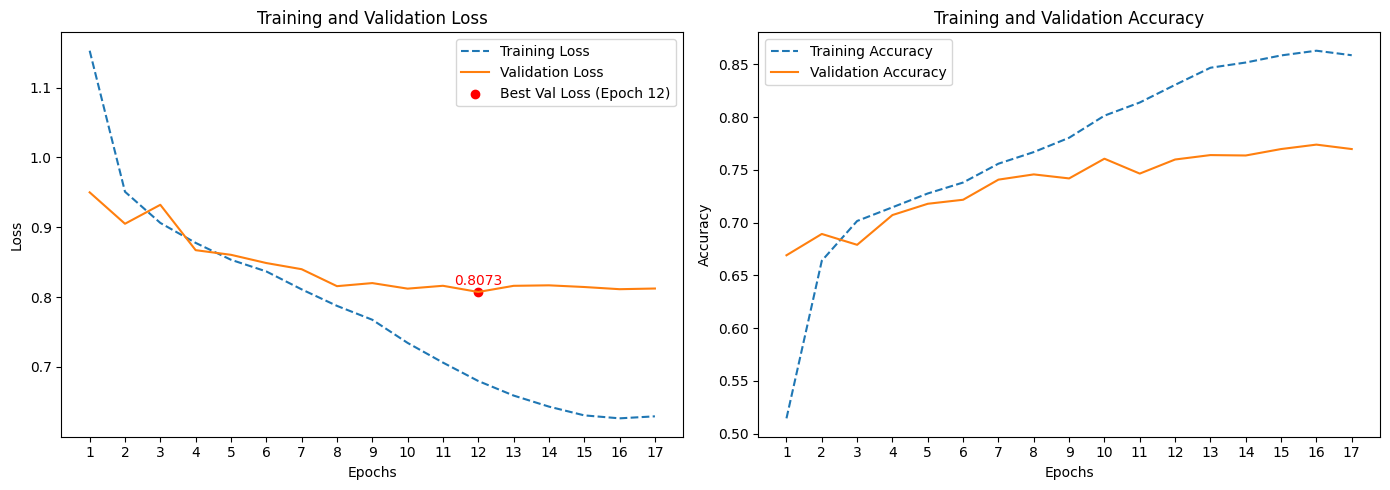

In [ ]:
# Find the epoch with the best validation loss
best_epoch = val_losses.index(min(val_losses))  # Index of the lowest validation loss
best_val_loss = val_losses[best_epoch]          # Value of the lowest validation loss

# Create the epoch range for x-axis ticks
epochs_range = range(1, len(train_losses) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss", linestyle='--')
plt.plot(epochs_range, val_losses, label="Validation Loss", linestyle='-')
plt.scatter(best_epoch + 1, best_val_loss, color='red', label=f"Best Val Loss (Epoch {best_epoch + 1})")  # Red marker
plt.text(best_epoch + 1, best_val_loss + 0.01, f"{best_val_loss:.4f}", color='red', fontsize=10, ha='center')
plt.xticks(epochs_range)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy", linestyle='--')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", linestyle='-')
plt.xticks(epochs_range)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig("mmodel_5e5_val_plot.png")
# Save confusion matrix plot
val_loss_acc_path = os.path.join(drive_save_dir, "model_5e5_val_plot.png")
plt.savefig(val_loss_acc_path)
print(f"Validation loss/accuracy plot saved to: {val_loss_acc_path}")
plt.show()


Evaluate the model

In [ ]:
# Evaluate the model on training, validation, and test data
def calculate_accuracy(loader, model, device):
   # Set the model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    # Disable gradient computation
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

train_accuracy = calculate_accuracy(train_loader, model, device)
val_accuracy = calculate_accuracy(val_loader, model, device)
test_accuracy = calculate_accuracy(test_loader, model, device)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8709
Validation Accuracy: 0.7696
Test Accuracy: 0.7811



Classification Report:
              precision    recall  f1-score   support

       angry       0.75      0.73      0.74       491
       happy       0.92      0.93      0.93       879
     neutral       0.73      0.73      0.73       626
         sad       0.66      0.66      0.66       594

    accuracy                           0.78      2590
   macro avg       0.76      0.76      0.76      2590
weighted avg       0.78      0.78      0.78      2590

Confusion matrix plot saved to: /content/drive/My Drive/Share/FER_fyp/Proposed_Model/testing/model_5e5_updates.png


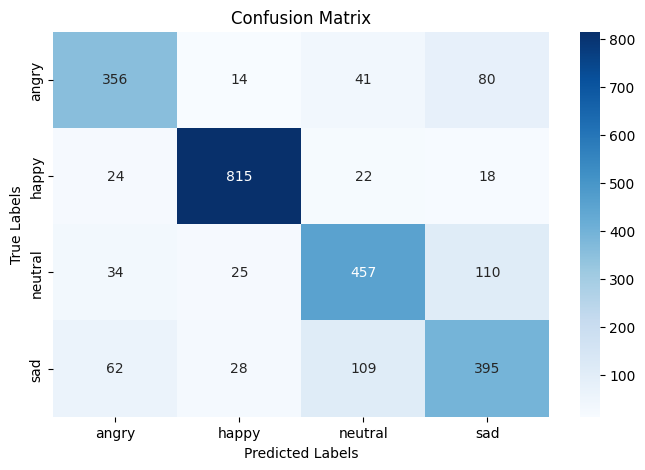

In [ ]:
# Evaluate the model on the test set to generate predictions
model.eval()
all_labels = []
all_predictions = []

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Classification Report
print("\nClassification Report:")
report = classification_report(all_labels, all_predictions, target_names=class_names_train)
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_train, yticklabels=class_names_train)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("model_5e5_updates.png")
# Save confusion matrix plot to Google Drive
conf_matrix_path = os.path.join(drive_save_dir, "model_5e5_updates.png")
plt.savefig(conf_matrix_path)
print(f"Confusion matrix plot saved to: {conf_matrix_path}")
plt.show()

# Music Streaming Service API Integration


---

This section integrates the trained ResNet18-CBAM model with Spotify API to generate emotion-aligned playlists.

#### Webcam Capturing

Installing packages and import libraries

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
import io
import base64
import cv2
import numpy as np

Capture a real-time photo of the tester using webcam

*This part of code is referenced from: https://github.com/theAIGuysCode/colab-webcam/blob/main/colab_webcam.ipynb*

In [ ]:
# Function to activate the webcam and display the video feed
def activate_camera():
    js = Javascript('''
        async function activateCamera() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            div.appendChild(video);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            // Add a button for capturing the photo
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            // Wait for the Capture button to be clicked
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg', 0.8);
        }
    ''')
    return js


# Function to capture and save a photo from the activated webcam
def take_photo(filename='photo.jpg', quality=0.8):
    """
    Captures a photo from the active webcam and saves it as a JPEG file.

    Args:
        filename (str): Name of the file to save the captured photo. Default is 'photo.jpg'.
        quality (float): Compression quality for the saved image (0 to 1). Default is 0.8.

    Returns:
        str: Path to the saved image file.
    """
    # Display the JavaScript for activating the camera and capturing the photo
    display(activate_camera())
    # Execute the JavaScript and retrieve the image data as base64
    data = eval_js('activateCamera()')
    # Decode the base64 data and save the image as a file
    binary = io.BytesIO(base64.b64decode(data.split(',')[1]))
    image = Image.open(binary)
    image.save(filename)
    print(f"Saved to {filename}")
    return filename

<IPython.core.display.Javascript object>

Saved to captured_testing.jpg


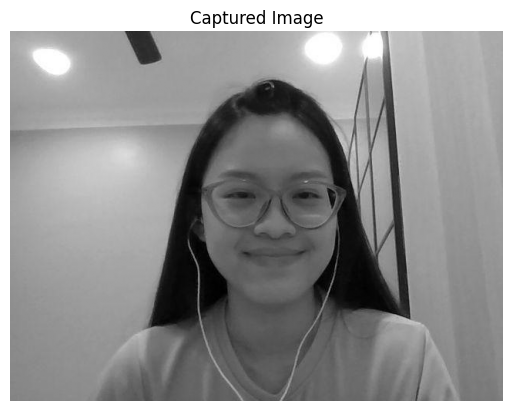

In [ ]:
# Capture the image
captured_file_path = 'captured_testing.jpg'
captured_file = take_photo(captured_file_path)

captured_img = cv2.imread(captured_file_path, cv2.IMREAD_GRAYSCALE)
# Display the captured image
if captured_img is not None:
    from matplotlib import pyplot as plt
    plt.imshow(captured_img, cmap='gray')
    plt.title('Captured Image')
    plt.axis('off')
    plt.show()
else:
    print("Image not found or failed to load!")

#### Facial Emotion Recognition

In [ ]:
import cv2
import numpy as np
import torch

# Function to process the captured image for facial recognition tasks
# The process includes detect face, convert to grayscale, and resize it.
def process_captured_image(image_path, target_size=(224, 224)):
    # Load Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Input file {image_path} not found.")

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))
    if len(faces) == 0:
        raise ValueError("No face detected in the image.")

    # Crop the first detected face
    x, y, w, h = faces[0]
    face = gray[y:y+h, x:x+w]

    # Resize the face to the target size
    resized_face = cv2.resize(face, target_size)

    # Normalize pixel values to [0, 1]
    normalized_face = resized_face / 255.0

    # Add channel and batch dimensions for PyTorch (1, 1, 224, 224)
    face_tensor = torch.tensor(normalized_face, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Move the tensor to the specified device
    face_tensor = face_tensor.to(device)

    return face_tensor


# Function to predict emotion
def predict_emotion(image_path):
    # Preprocess the image
    img_tensor = process_captured_image(image_path)

    # Make the prediction
    with torch.no_grad():
        output = model(img_tensor) # Forward pass
        predicted_class = torch.argmax(output, dim=1).item() # Get the predicted class index

    # Map the predicted class index to the corresponding emotion label
    emotion = class_names[predicted_class]

    return emotion


Load the trained model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "model_5e5.pth"
num_classes = 4
model = ResNet18_CBAM(num_classes=num_classes).to(device)
model.base_model.fc = nn.Sequential(
    nn.Dropout(p=0.7),
    nn.Linear(512, num_classes)
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18_CBAM(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

Predict the user's emotion

Predicted Emotion: Happy


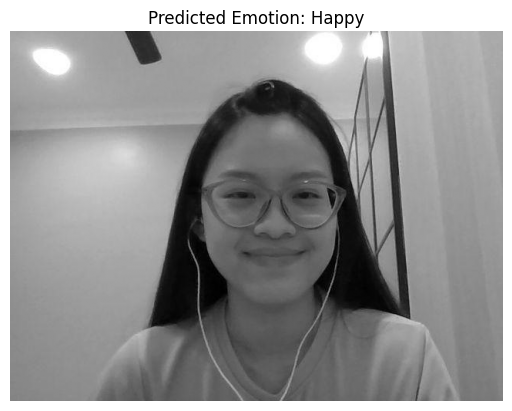

In [ ]:
# Define the path to a test image
captured_file_path = "captured_testing.jpg"

# Define the emotion labels
class_names = ["Angry", "Happy", "Neutral", "Sad"]

# Predict emotion
predicted_emotion = predict_emotion(captured_file_path)
print(f"Predicted Emotion: {predicted_emotion}")

# Display the image with the predicted emotion
captured_img = cv2.imread(captured_file_path, cv2.IMREAD_GRAYSCALE)
if captured_img is not None:
    from matplotlib import pyplot as plt
    plt.imshow(captured_img, cmap='gray')
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis('off')
    plt.show()
else:
    print("Image not found or failed to load!")

### Spotify API Integration

Import required libraries for integrating Spotify API

In [ ]:
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyOAuth

!pip install python-dotenv
import os
from dotenv import load_dotenv

Set up Spotify credentials using OAuth

*This part of code is referenced from: https://github.com/SyedsPortfolio/Spotify-Recommendation-System/blob/main/Spotify_Recommendation_System.ipynb*

In [ ]:
load_dotenv()

In [ ]:
# Get Spotify credentials securely
SPOTIPY_CLIENT_ID = os.getenv("SPOTIPY_CLIENT_ID")
SPOTIPY_CLIENT_SECRET = os.getenv("SPOTIPY_CLIENT_SECRET")
SPOTIPY_REDIRECT_URI = os.getenv("SPOTIPY_REDIRECT_URI")

scope = "playlist-modify-private playlist-read-private user-library-read"

# Set up SpotifyOAuth
auth_manager = SpotifyOAuth(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET,
    redirect_uri=SPOTIPY_REDIRECT_URI,
    scope=scope,
    open_browser=False
)

In [ ]:
# Generate the authentication URL
auth_url = auth_manager.get_authorize_url()
print("Click the link below to authenticate:")
print(auth_url)

# Paste the redirected URL after logging in
redirected_url = input("Paste the redirected URL here: ")

# Extract the authorization code
auth_code = auth_manager.parse_response_code(redirected_url)

# Fetch the access token using the authorization code
token_info = auth_manager.get_access_token(code=auth_code)

# Use the token to create a Spotify client
sp = spotipy.Spotify(auth=token_info['access_token'])

# Test the connection
current_user = sp.current_user()
print(f"Spotify authenticated successfully! Logged in as {current_user['display_name']}")


Click the link below to authenticate:
https://accounts.spotify.com/authorize?client_id=f7aaeee0af114536a38ecff0ec2b1e44&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8989%2F&scope=playlist-modify-private+playlist-read-private+user-library-read
Paste the redirected URL here: http://localhost:8989/?code=AQCAXoP4-X7aehqIznpiQHoip-NPfpJzKQshx-hzXHQ8Pi77mE9__h5cjgziRh2kP11aviPvEoJLGjBUYHd2DhS3wMWccC4bT5qlktQTr2ZFD_6ApUPep3SECMAm1aJh_nVrrRf455eRKeURKs9ExoCFN0fVL4dYz3bqqEHahX8L1ts1qLI1hIvL9CozbEKi_KqEYZD8A5-jAW8UlUYOVZbL2ad8gwVf_JpwYtfvPhrdu2f813wAIjR94P_5
Spotify authenticated successfully! Logged in as Renaaaaa


<ipython-input-27-0e45a5151c88>:13: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token_info = auth_manager.get_access_token(code=auth_code)


Fetch tracks that align with the detected emotion and generating an emotion-based playlist

In [ ]:
# Function to search playlists by emotion keywords and fetches tracks from the playlist.
def fetch_tracks_from_playlists(emotion, limit=10):

  # Predefined emotion-aligned playlist keywords
  # these keywords are culturally intuitive, people commonly associate specifci terms with mood
  emotion_keywords = {
      "Happy": ["Happy", "Good", "Joy", "Pop"],
      "Sad": ["Sad", "Cry", "Tear", "Depression"],
      "Angry": ["Angry", "Annoyed", "Rage", "Agressive"],
      "Neutral": ["Calm", "Chilling", "Relaxed", "Ambiance"]
  }

  # Check if emotion keyword can fetch the related playlist
  keywords = emotion_keywords.get(emotion, [])
  if not keywords:
      print(f"No keywords found for emotion: {emotion}")
      return []

  # Define a list to store fetched tracks
  tracks = []

  # Search for playlists by emotion keywords
  for keyword in keywords:
      try:
          print(f"Searching playlists with keyword: {keyword}")
          search_results = sp.search(q=keyword, type="playlist", limit=1)  # Limit to 1 playlist per keyword

          # Extract the first playlist's tracks
          if search_results['playlists']['items']:
              playlist = search_results['playlists']['items'][0]
              playlist_id = playlist['id']
              print(f"Found playlist: {playlist['name']} (ID: {playlist_id})")

              # Get tracks info from the playlist
              playlist_tracks = sp.playlist_tracks(playlist_id, limit=limit)
              for item in playlist_tracks['items']:
                  track = item['track']
                  print(f"Track found: {track['name']} by {track['artists'][0]['name']}")
                  tracks.append(track['uri'])
          else:
              print(f"No playlists found with keyword: {keyword}")

      except Exception as e:
          print(f"Error searching playlists with keyword '{keyword}': {e}")

  # Return a list of unique tracks (Remove duplicates)
  unique_tracks = list(set(tracks))
  print(f"Fetched {len(unique_tracks)} unique tracks for emotion: {emotion}")
  return unique_tracks


# Function to create a new playlist for a specific emotion and adds tracks to it.
def create_emotion_playlist(user_id, emotion, track_uris):
  # Create a playlist name based on the emotion
  playlist_name = f"{emotion} Vibes Playlist"
  try:
    # Create a new playlist
    playlist = sp.user_playlist_create(user=user_id, name=playlist_name, public=False)
    playlist_id = playlist['id']
    # Adds the given tracks 'track_uris' into the playlist
    sp.playlist_add_items(playlist_id, track_uris)
    # Return the playlist link to access
    playlist_link = playlist['external_urls']['spotify']
    print(f"`{playlist_name}` is created successfully!!")
    print(f"Access it here: {playlist_link}")
    return playlist_link
  except Exception as e:
      print(f"Error creating playlist: {e}")
      return None

In [ ]:
# Fetch tracks for predicted emotion
track_uris = fetch_tracks_from_playlists(predicted_emotion)
print(f"Fetched track URIs: {track_uris}")

# Generate a playlist based on the predicted emotion with the fetched tracks
if track_uris:
  user_id = sp.current_user()["id"]
  playlist_link = create_emotion_playlist(user_id, predicted_emotion, track_uris)

Searching playlists with keyword: Happy
Found playlist: Pharrell Williams - Happy (ID: 5UgG3XS8q1lgsnHqRi6Qle)
Track found: Happy by Pharrell Williams
Track found: Uptown Funk (feat. Bruno Mars) by Mark Ronson
Searching playlists with keyword: Good
Found playlist: Good luck babe! Loop ❤️🎧 (ID: 0PNJqmu1AzENjQ5pEm5wRQ)
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Track found: Good Luck, Babe! by Chappell Roan
Searching playlists with keyword: Joy
Found playlist: GLISTEN JOYRIDE  (ID: 1dtfP6g6YiM5qtlH8FfQfO)
Track found: JOYRIDE by Kesha
Track found: KEEP UP by Odetari
Track found: FΛSHION by Britney Manson
Track foun